# Chennai Floods 2015–A Geographic Analysis

On December 1–2, 2015, the Indian city of Chennai received more rainfall in 24 hours than it had seen on any day since 1901. The deluge followed a month of persistent monsoon rains that were already well above normal for the Indian state of Tamil Nadu. At least 250 people had died, several hundred had been critically injured, and thousands had been affected or displaced by the flooding that has ensued.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chennai-Floods-2015–A-Geographic-Analysis" data-toc-modified-id="Chennai-Floods-2015–A-Geographic-Analysis-1">Chennai Floods 2015–A Geographic Analysis</a></span><ul class="toc-item"><li><span><a href="#Summary-of-this-sample" data-toc-modified-id="Summary-of-this-sample-1.1">Summary of this sample</a></span></li><li><span><a href="#Chennai-Floods-Explained" data-toc-modified-id="Chennai-Floods-Explained-1.2">Chennai Floods Explained</a></span></li><li><span><a href="#How-much-rain-and-where?" data-toc-modified-id="How-much-rain-and-where?-1.3">How much rain and where?</a></span></li><li><span><a href="#Spatial-Analysis" data-toc-modified-id="Spatial-Analysis-1.4">Spatial Analysis</a></span></li><li><span><a href="#What-caused-the-flooding-in-Chennai?" data-toc-modified-id="What-caused-the-flooding-in-Chennai?-1.5">What caused the flooding in Chennai?</a></span><ul class="toc-item"><li><span><a href="#A-wrong-call-that-sank-Chennai" data-toc-modified-id="A-wrong-call-that-sank-Chennai-1.5.1">A wrong call that sank Chennai</a></span></li></ul></li><li><span><a href="#Flood-Relief-Camps" data-toc-modified-id="Flood-Relief-Camps-1.6">Flood Relief Camps</a></span><ul class="toc-item"><li><span><a href="#Routing-Emergency-Supplies-to-Relief-Camps" data-toc-modified-id="Routing-Emergency-Supplies-to-Relief-Camps-1.6.1">Routing Emergency Supplies to Relief Camps</a></span></li></ul></li></ul></li></ul></div>

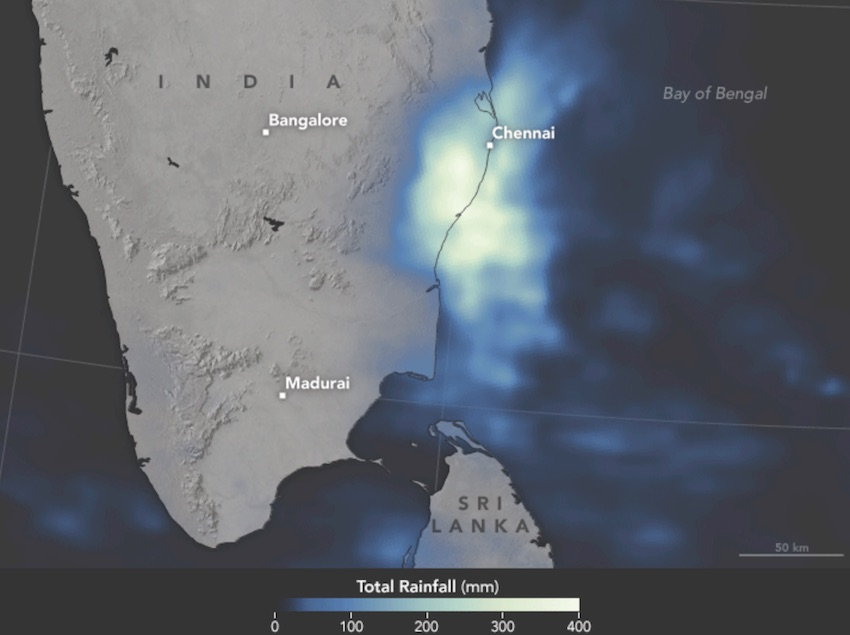

The image above provides satellite-based estimates of rainfall over southeastern India on December 1–2, accumulating in 30–minute intervals. The rainfall data is acquired from the Integrated Multi-Satellite Retrievals for GPM (IMERG), a product of the [Global Precipitation Measurement](http://www.nasa.gov/mission_pages/GPM/main/index.html) mission. The brightest shades on the maps represent rainfall totals approaching 400 millimeters (16 inches) during the 48-hour period. These regional, remotely-sensed estimates may differ from the totals measured by ground-based weather stations. According to Hal Pierce, a scientist on the GPM team at NASA’s Goddard Space Flight Center, the highest rainfall totals exceeded 500 mm (20 inches) in an area just off the southeastern coast.

[Source: NASA http://earthobservatory.nasa.gov/IOTD/view.php?id=87131]

## Summary of this sample
This sample showcases not just the analysis and visualization capabilities of your GIS, but also the ability to store illustrative text, graphics and live code in a Jupyter notebook.

The sample starts off reporting the devastating effects of the flood. We plot the locations of rainfall guages and **interpolate** the data to create a continuous surface representing the amount of rainfall throughout the state.

Next we plot the locations of major lakes and **trace downstream** the path floods waters would take. We create a **buffer** around this path to demark at risk areas.

In the second part of the sample, we take a look at **time series** satellite imagery and observe the human impacts on natural reservoirs over a period of two decades.

We then vizualize the locations of relief camps and analyze their capacity using **pandas** and **matplotlib**. We **aggregate** the camps district wise to understand which ones have the largest number of refugees.

In the last part, we perform a **routing** analysis to figure out the best path to route emergency supplies from storage to the relief camps

First, let's import all the necessary libraries and connect to our GIS.

In [1]:
import datetime

%matplotlib inline
import matplotlib.pyplot as pd
from IPython.display import display, YouTubeVideo

import arcgis
from arcgis.gis import GIS
from arcgis.features.analyze_patterns import interpolate_points
from arcgis.geocoding import geocode
from arcgis.features.find_locations import trace_downstream
from arcgis.features.use_proximity import create_buffers

gis = GIS("https://www.arcgis.com", "arcgis_python", "P@ssword123")


## Chennai Floods Explained

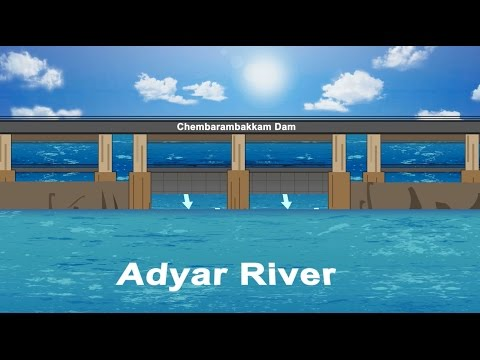

In [1]:
YouTubeVideo('x4dNIfx6HVs')

The catastrophic flooding in Chennai is the result of the heaviest rain in several decades, which forced authorities to release a massive 30,000 cusecs from the Chembarambakkam reservoir into the Adyar river over two days, causing it to flood its banks and submerge neighbourhoods on both sides. It did not help that the Adyar’s stream is not very deep or wide, and its banks have been heavily encroached upon over the years.
Similar flooding triggers were in action at Poondi and Puzhal reservoirs, and the Cooum river that winds its way through the city.
While Chief Minister J Jayalalithaa said, during the earlier phase of heavy rain last month, that damage during the monsoon was “inevitable”, the fact remains that the mindless development of Chennai over the last two decades — <b>the filling up of lowlands and choking of stormwater drains and other exits for water — has played a major part in the escalation of the crisis.</b>

[Source: Indian Express http://indianexpress.com/article/explained/why-is-chennai-under-water/#sthash.LlhnqM4B.dpuf]

## How much rain and where?

To get started with our analysis, we bring in a map of the affected region. The map is a live widget that is internally using the ArcGIS JavaScript API.


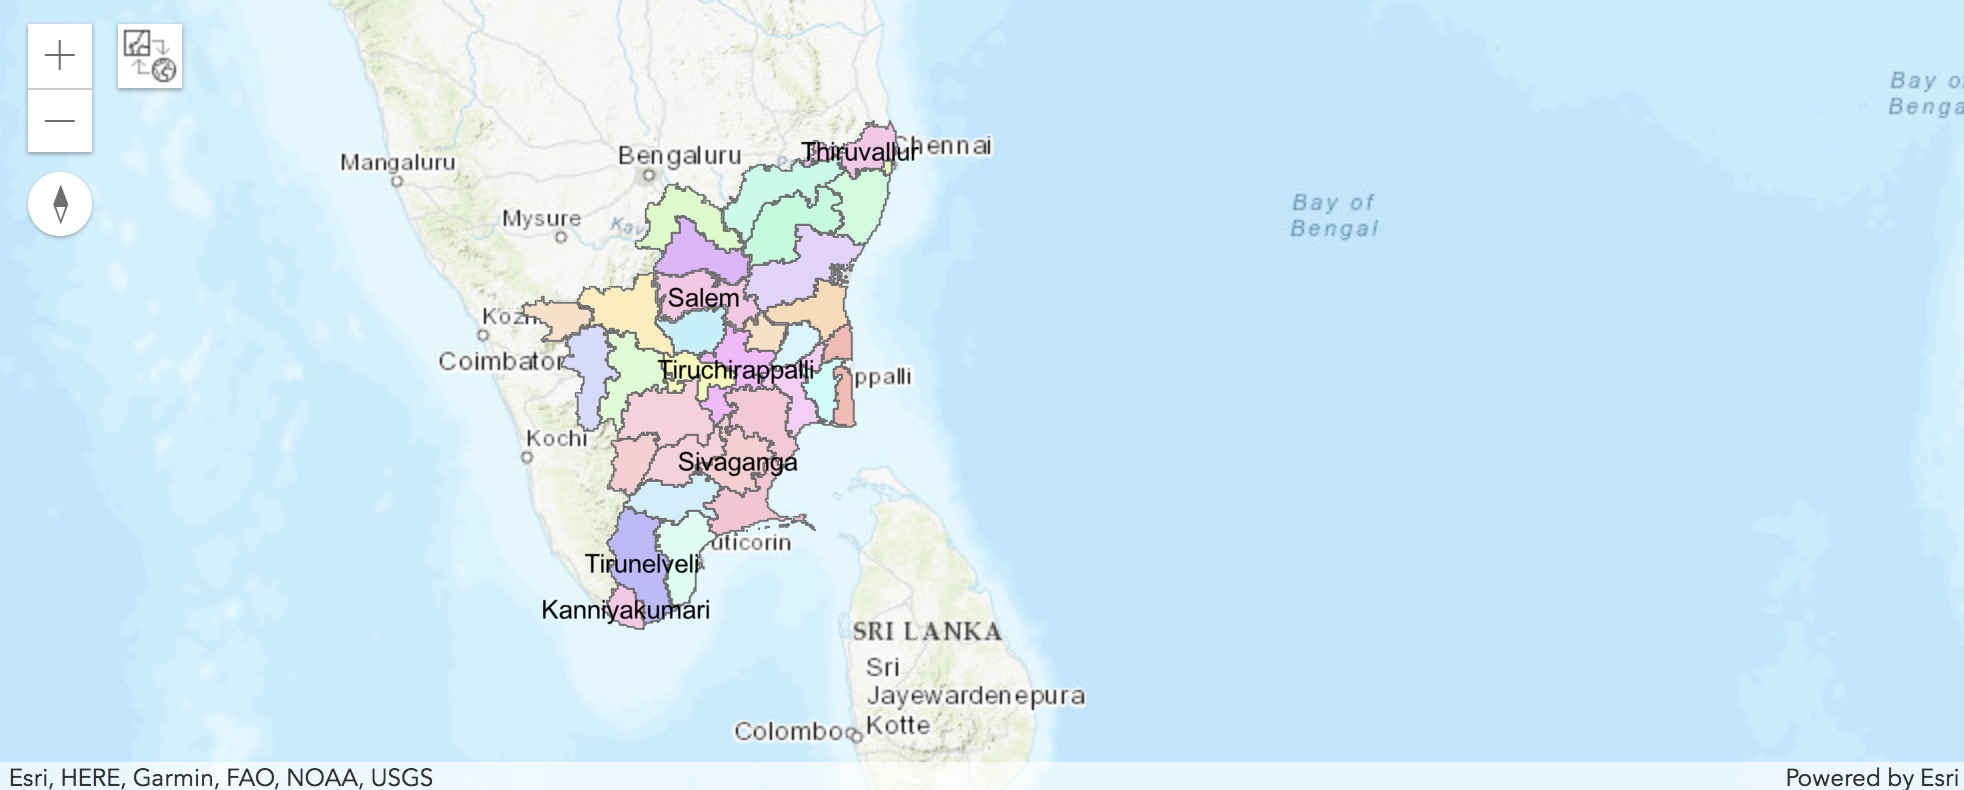

In [81]:
map = gis.map("Chennai")
map

We can search for content in our GIS and add layers to our map that can be used for visualization or analysis:

<Item title:"Chennai Solid Waste Management" type:Feature Layer Collection owner:amani001>
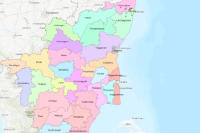

In [16]:
chennaipop = gis.content.search("Solid Waste Management- TN", 
                                item_type="feature service", 
                                outside_org=True)[0]
chennaipop

In [17]:
map.add_layer(chennaipop)

To get a sense of how much it rained and where, let's use rainfall data for December 2nd 2015, obtained from the Regional Meteorological Center in Chennai. Tabular data is hard to visualize, so let's bring in a map from our GIS to visualize the data:

In [18]:
rainfall = gis.content.search("Chennai_precipitation", 
                              item_type="feature service", 
                              outside_org=True)[0]
rainfall


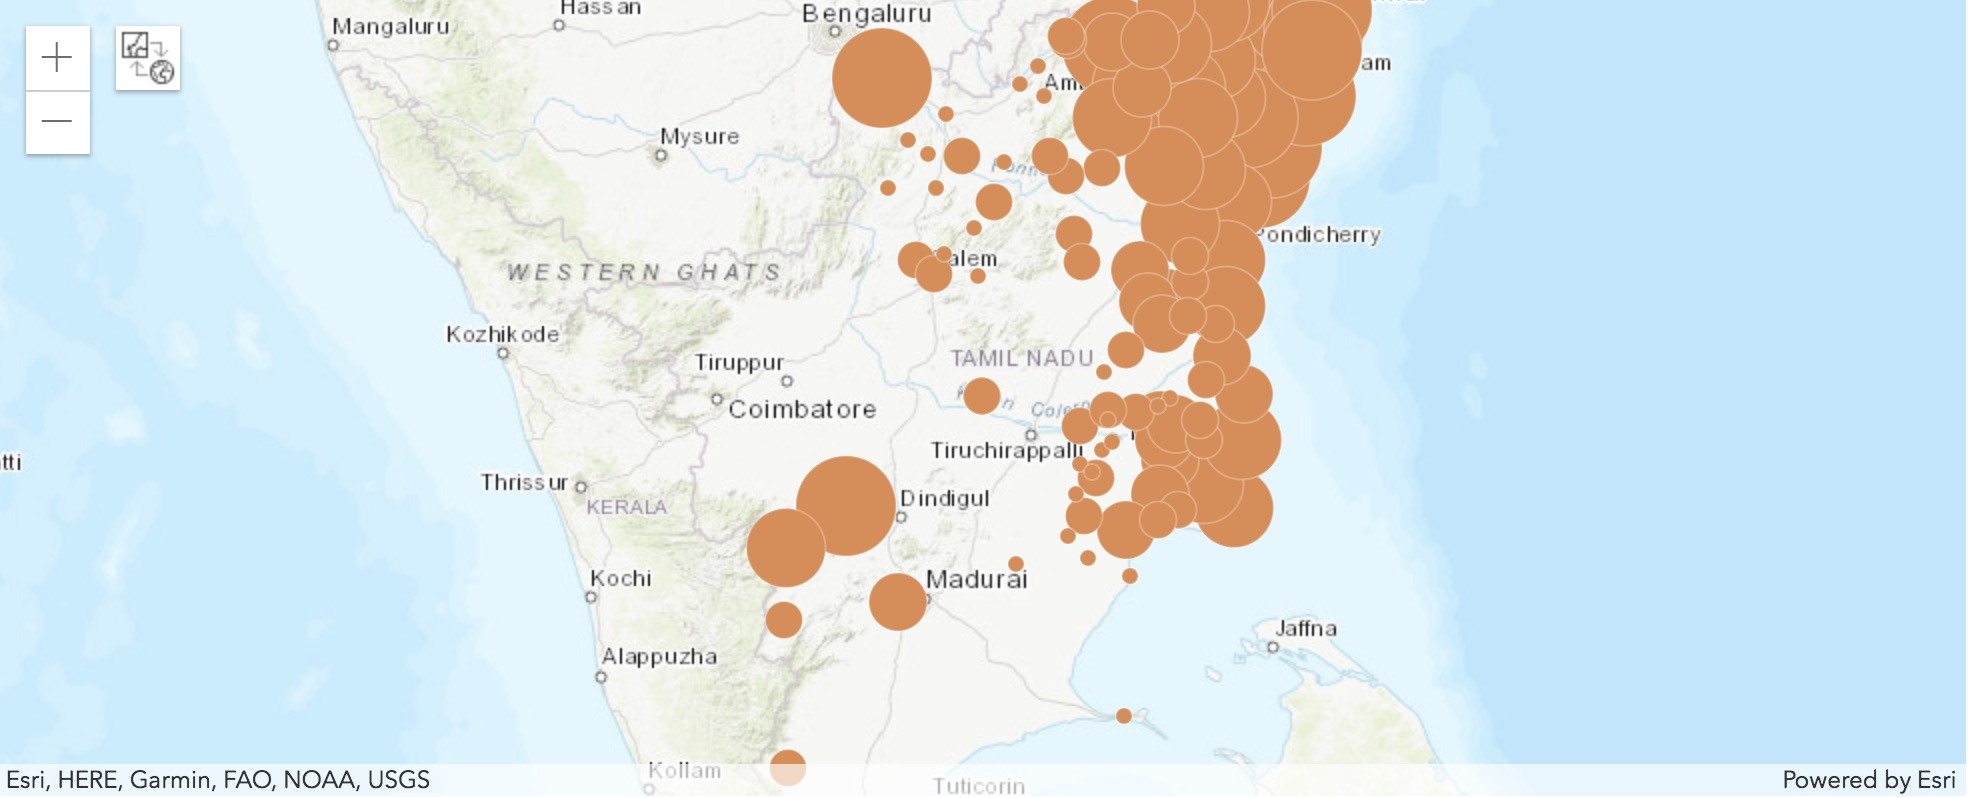

In [83]:
map2 = gis.map("Tamil Nadu, India")
map2

We then add this layer to our map to see the locations of the weather stations from which the rainfall data was collected:

In [20]:
map2.add_layer(rainfall, {"renderer":"ClassedSizeRenderer", 
                          "field_name":"RAINFALL" })

Here we used the **smart mapping** capability of the GIS to automatically render the data with proportional symbols.

## Spatial Analysis
Rainfall is a continuous phenonmenon that affects the whole region, not just the locations of the weather stations. Based on the observed rainfall at the monitoring stations and their locations, we can interpolate and deduce the approximate rainfall across the whole region. We use the **Interpolate Points** tool from the GIS's spatial analysis service for this.

The Interpolate Points tool uses <a href="http://desktop.arcgis.com/en/desktop/latest/guide-books/extensions/geostatistical-analyst/what-is-empirical-bayesian-kriging-.htm">empirical Bayesian kriging</a> to perform the interpolation.

In [22]:
interpolated_rf = interpolate_points(rainfall, field='RAINFALL')

Let us create another map of Tamil Nadu state and render the output from Interpolate Points tool


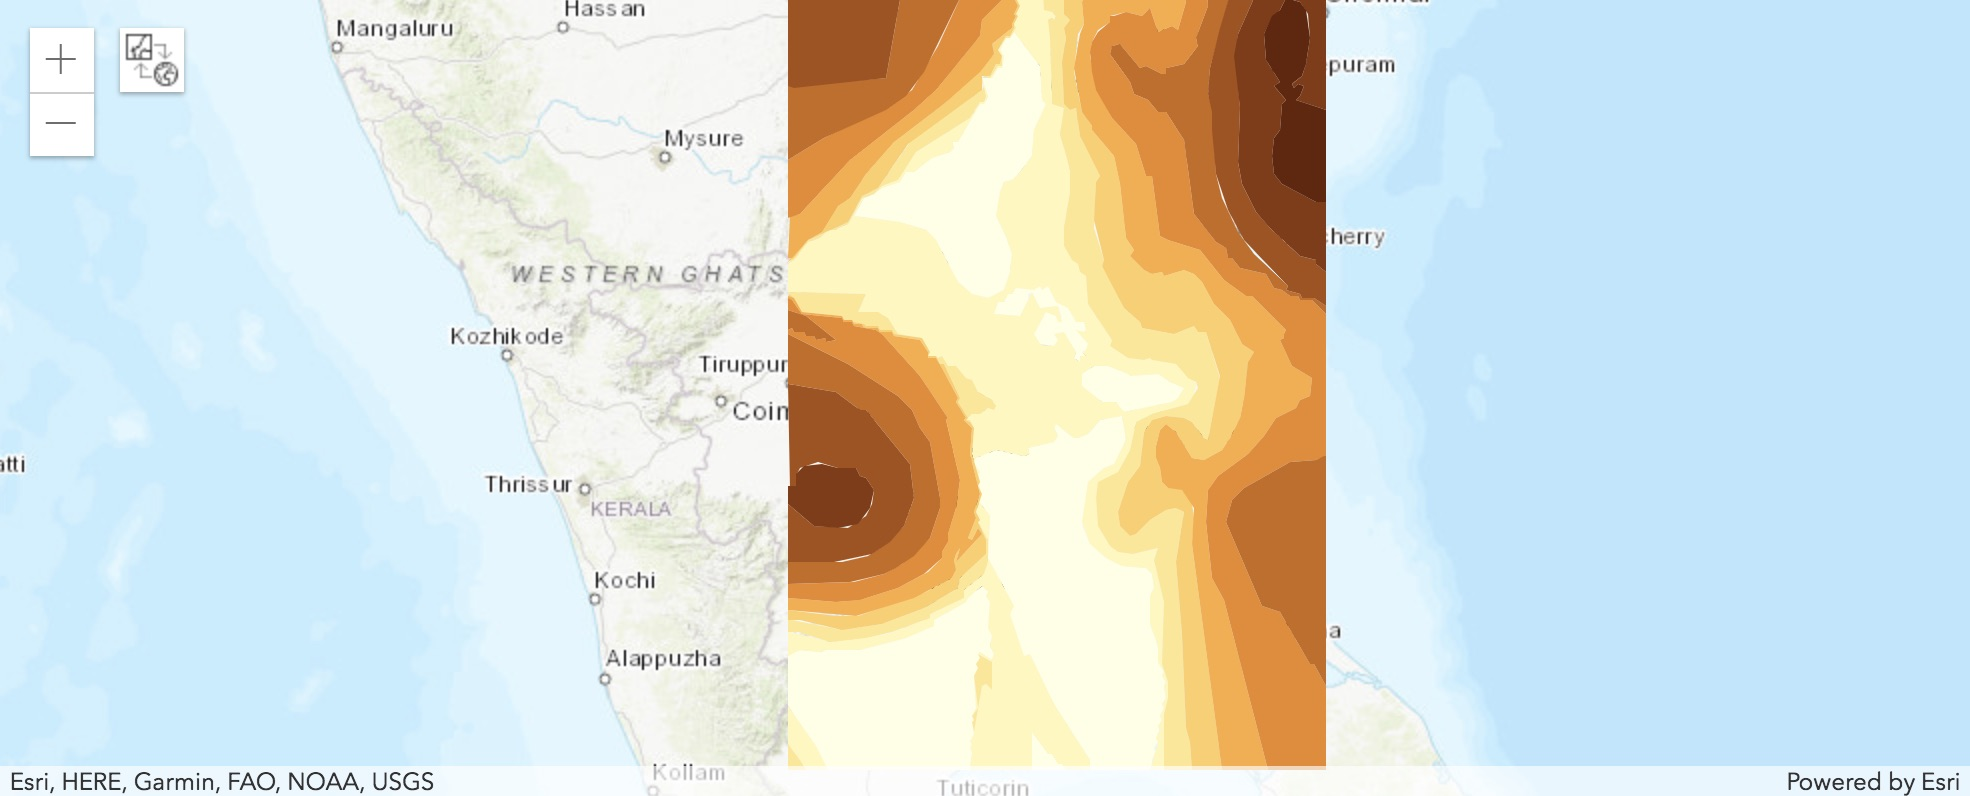

In [84]:
intmap = gis.map("Tamil Nadu")
intmap

In [26]:
intmap.add_layer(interpolated_rf['result_layer'])

We see that rainfall was most severe in and around Chennai as well some parts of central Tamil Nadu.

## What caused the flooding in Chennai?

### A wrong call that sank Chennai
Much of the flooding and subsequent waterlogging was a consequence of the outflows from major reservoirs into swollen rivers and into the city following heavy rains. The <b>release of waters from the Chembarambakkam reservoir</b> in particular has received much attention. [Source: The Hindu, http://www.thehindu.com/news/cities/chennai/chennai-floods-a-wrong-call-that-sank-the-city/article7967371.ece]


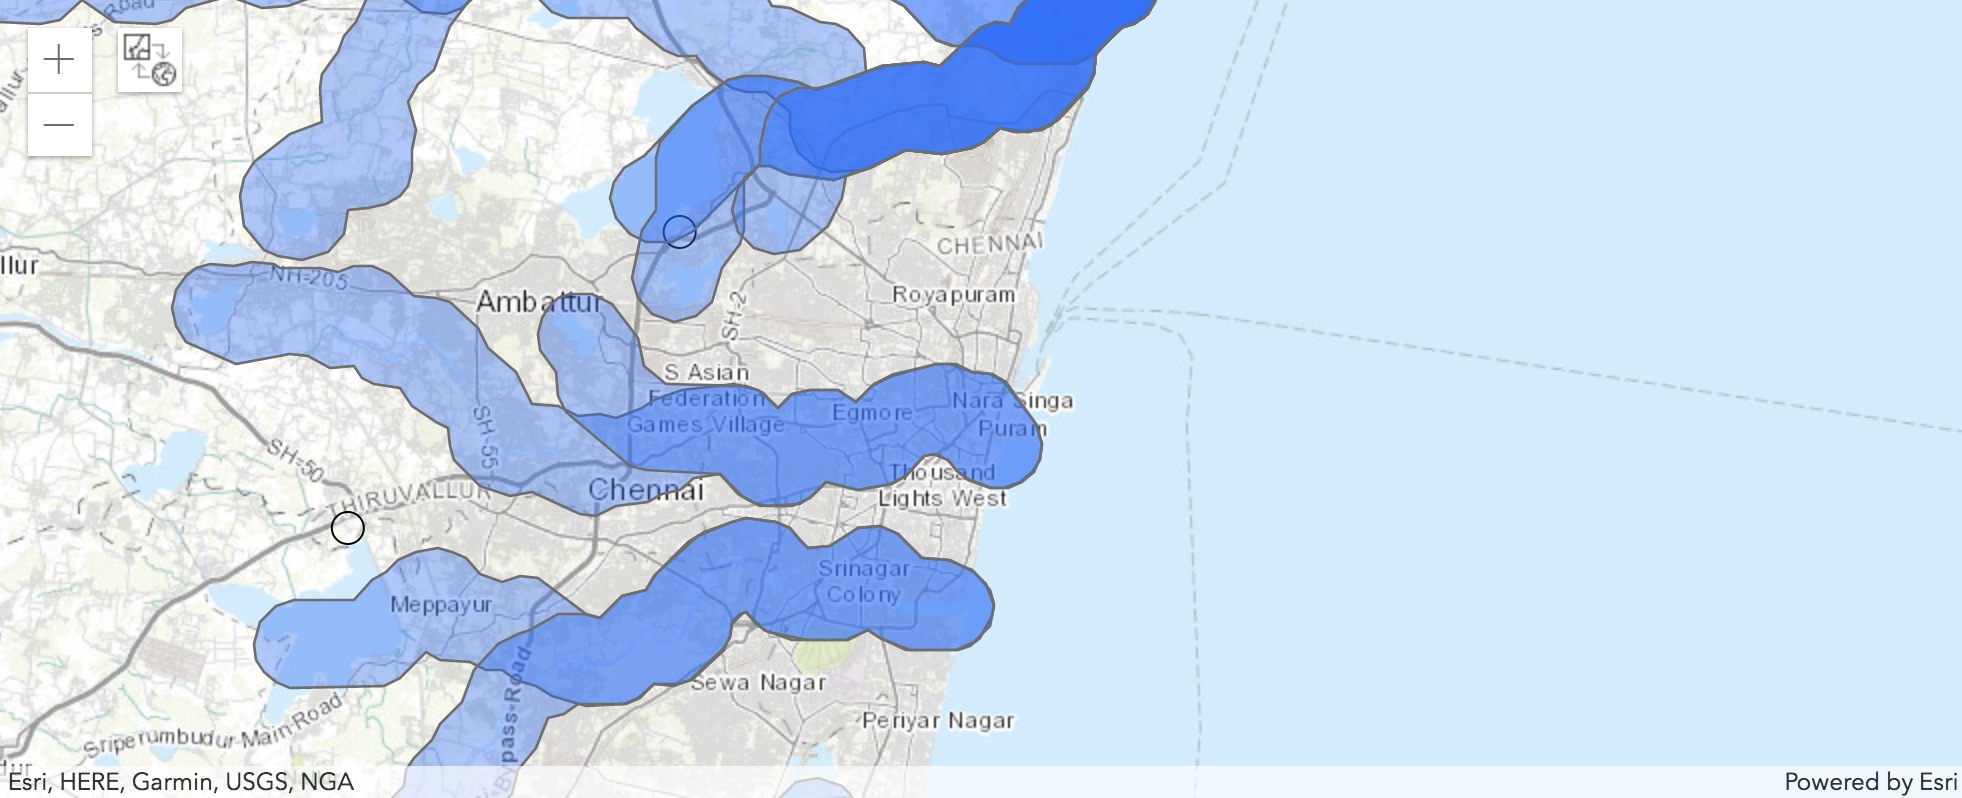

In [85]:
lakemap = gis.map("Chennai")
lakemap.height='450px'
lakemap

Let's have look at the major lakes and water reservoirs that were filled to the brim in Chennai due the rains. We plot the locations of some of the reservoirs that had a large outflow during the rains:

To plot the locations, we use geocoding tools from the `tools` module. Your GIS can have more than 1 geocoding service, for simplicity, the sample below chooses the first available geocoder to perform an address search

In [30]:
lakemap.draw(geocode("Chembarambakkam, Tamil Nadu")[0], 
             {"title": "Chembarambakkam", "content": "Water reservoir"})
lakemap.draw(geocode("Puzhal Lake, Tamil Nadu")[0], 
             {"title": "Puzhal", "content": "Water reservoir"})
lakemap.draw(geocode("Kannampettai, Tamil Nadu")[0], 
             {"title": "Poondi Lake ", "content": "Water reservoir"})

To identify the flood prone areas, let's trace the path that the water would take when released from the lakes. To do this, we first bring in a layer of lakes in Chennai:

In [2]:
search_results = gis.content.search("Chennai_lakes", 
                                   item_type="feature service",
                                   outside_org=True)
search_results

[<Item title:"Chennai Lakes OverFlow Path" type:Feature Layer Collection owner:Balaganesh99>,
 <Item title:"Possible Flood Zones" type:Feature Layer Collection owner:Balaganesh99>,
 <Item title:"Chennai_lakes" type:Feature Layer Collection owner:yjiang_geosaurus>]

<Item title:"Chennai_lakes" type:Feature Layer Collection owner:yjiang_geosaurus>
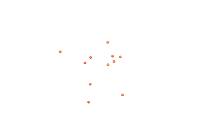

In [3]:
chennai_lakes = search_results[2]
chennai_lakes

Now, let's call the **`Trace Downstream`** analysis tool from the GIS:

In [33]:
downstream = trace_downstream(chennai_lakes)
downstream.query()

<FeatureSet> 11 features

The areas surrounding the trace paths are most prone to flooding and waterlogging. To identify the areas that were at risk, we buffer the traced flow paths by one mile in each direction and visualize it on the map. We see that large areas of the city of Chennai were susceptible to flooding and waterlogging.

In [34]:
floodprone_buffer = create_buffers(downstream, [ 1 ], units='Miles')

In [35]:
lakemap.add_layer(floodprone_buffer)

## Flood Relief Camps

To provide emergency assistance, the Tamil Nadu government has set up several flood relief camps in the flood affected areas. They provide food, shelter and the basic necessities to thousands of people displaced by the floods. The locations of the flood relief camps was obtained from http://cleanchennai.com/floodrelief/2015/12/09/relief-centers-as-on-8-dec-2015/ and published to the GIS as a layer, that is visualized below:

In [36]:
relief_centers = gis.content.search("Chennai Relief Centers")[0]


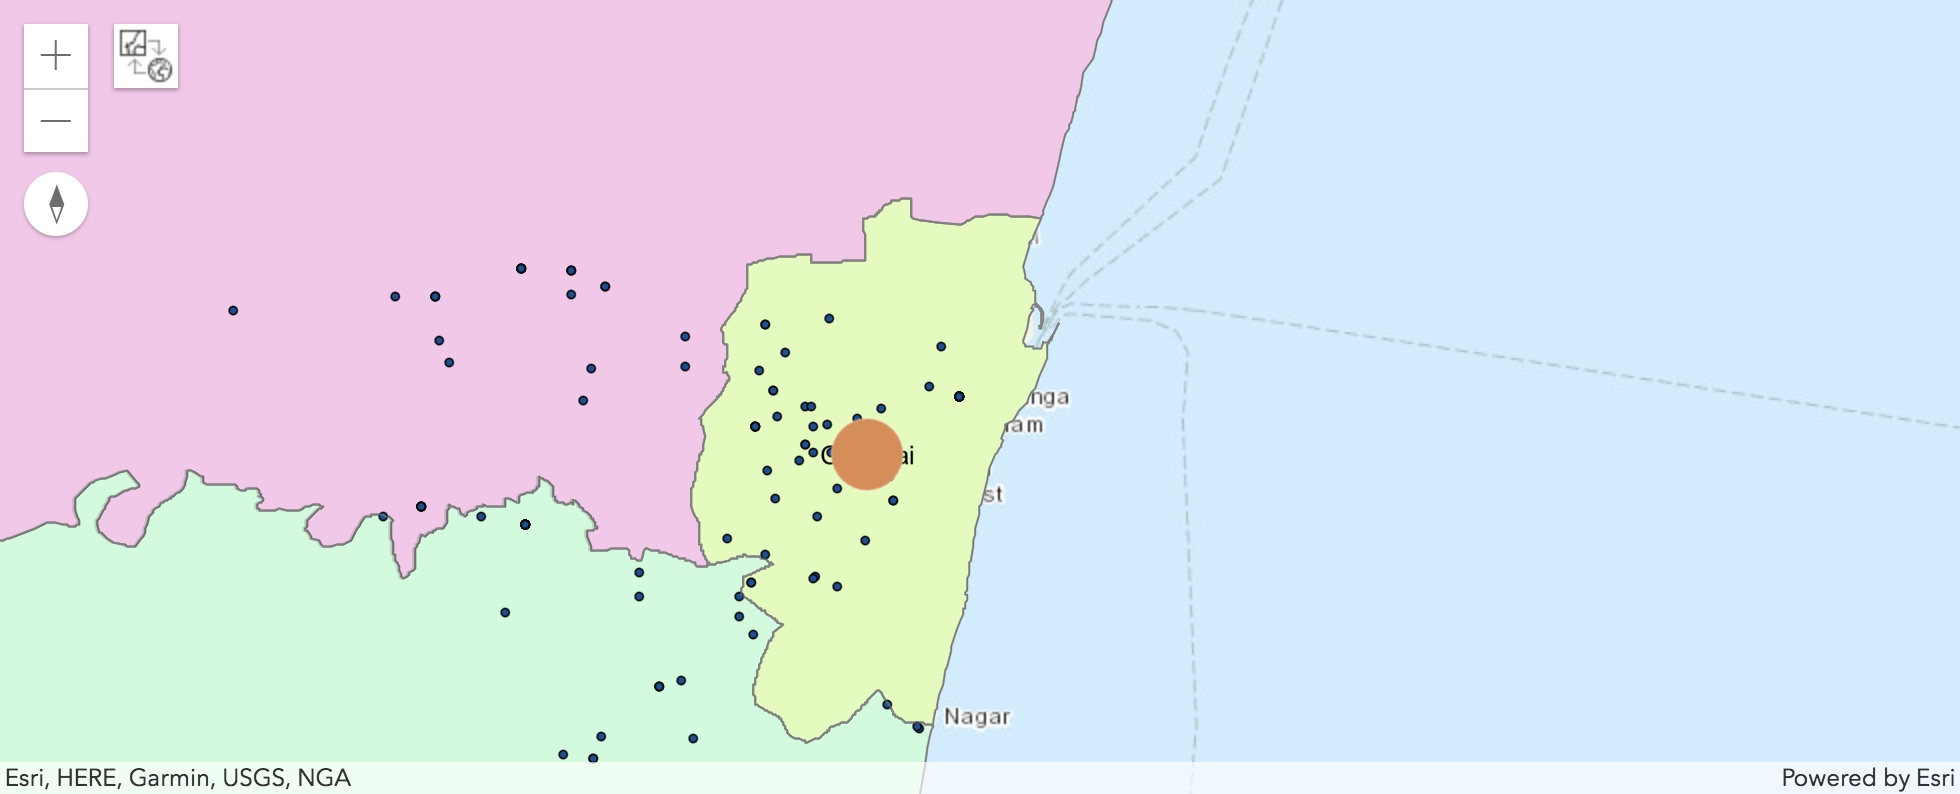

In [86]:
reliefmap = gis.map("Chennai")
reliefmap

In [41]:
reliefmap.add_layer(chennaipop)

In [42]:
reliefmap.add_layer(relief_centers)

Let us read the relief center layer as a pandas dataframe to analyze the data further

In [43]:
relief_data = relief_centers.layers[0].query().sdf
relief_data.head()

,SHAPE,contact_no,division__,f_locations,fid,no_of_cent,no_of_fami,no_of_pers,sl_no_,symbolid,zone______
0,"{""x"": 8919695.334200002, ""y"": 1464332.82630000...","Balamurali, 9445190311",10,"Poonthotam School, Chennai",1,10,65,200,1,,I
1,"{""x"": 8936283.704100005, ""y"": 1469202.82020000...","Jayakumar, 9445190302",2,"St.Joseph church community Hall, Chennai",2,0,200,600,2,,
2,"{""x"": 8916764.954599999, ""y"": 1450941.69069999...","Jayakumar, 9445190302",2,"Nehru Nagar chennai Middle school, Chennai",3,0,75,250,3,,
3,"{""x"": 8924034.069200002, ""y"": 1462457.79919999...","Shanmugam, 9445190301",7,"Kalaimagal School, Chennai",4,0,15,50,4,,
4,"{""x"": 8919695.334200002, ""y"": 1464332.82630000...","Rameshkumar, 9445190304",4,"Ramanathapuram School, Chennai",5,0,100,300,5,,


In [47]:
relief_data['No_of_pers'].sum()

31478

In [48]:
relief_data['No_of_pers'].describe()

count     136.000000
mean      231.455882
std       250.334202
min        10.000000
25%        60.000000
50%       150.000000
75%       300.000000
max      1500.000000
Name: no_of_pers, dtype: float64

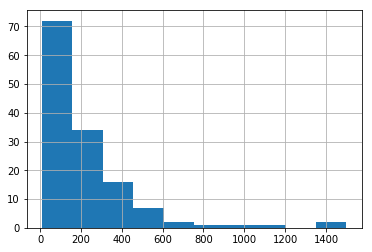

In [50]:
relief_data['No_of_pers'].hist()

In our dataset, each row represents a relief camp location. To quickly get the dimensions (rows & columns) of our data frame, we use the `shape` property

In [51]:
relief_data.shape

(136, 11)

As of 8th December, 2015, there were 31,478 people in the 136 relief camps. Let's aggregate them by the district the camp is located in. To accomplish this, we use the `aggregate_points` tool.

In [52]:
chennai_pop_featurelayer = chennaipop.layers[0]

In [54]:
res = arcgis.features.summarize_data.aggregate_points(
    relief_centers, 
    chennai_pop_featurelayer, 
    False, 
    ["No_of_pers Sum"])

In [55]:
aggr_lyr = res['aggregated_layer']

In [59]:
reliefmap.add_layer(aggr_lyr, { "renderer": "ClassedSizeRenderer", 
                               "field_name":"SUM_No_of_pers"})

In [60]:
df = aggr_lyr.query().sdf
df.head()

,AnalysisArea,Point_Count,SHAPE,SUM_no_of_pers,district_n,districtco,fid,lcya_avail,lcya_balan,lcya_requi,...,vapc_tract,vapc_tri_c,vasct_comp,vasct_dump,vasct_ecfe,vasct_jcb,vasct_lorr,vasct_othe,vasct_trac,year
0,1304.702697,27,"{""rings"": [[[8927226.489100002, 1470373.014199...",4063,Thiruvallur,602,9,18.18,42.790001,60.970001,...,5,62,5,4,0,1,17,0,3,2014
1,67.720230,64,"{""rings"": [[[8927223.1496, 1470310.1543999985]...",19045,Chennai,603,12,22.48,25.000000,30.000000,...,0,64,2,4,0,1,4,0,2,2014
2,1722.709824,45,"{""rings"": [[[8914096.3552, 1464672.7712000012]...",8370,Kancheepuram,604,15,61.91,35.900002,55.900002,...,4,178,4,7,2,3,10,2,7,2014


Let us represent the aggreate result as a table:

In [62]:
df = aggr_lyr.query().sdf

df2 = df[['district_name', 'SUM_No_of_pers']]
df2.set_index('district_name', inplace=True)
df2

,SUM_no_of_pers
district_n,
Thiruvallur,4063
Chennai,19045
Kancheepuram,8370


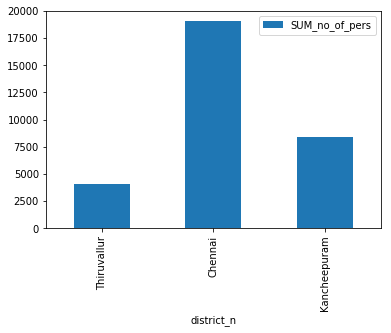

In [63]:
df2.plot(kind='bar')

### Routing Emergency Supplies to Relief Camps

A centralized location has been established at Nehru Stadium to organise the relief materials collected from various organizations and volunteers.  From there, the relief material is distributed to the needy flood affected people.

The GIS provided routing tools that can help plan routes of the relief trucks from the center to relief camps:


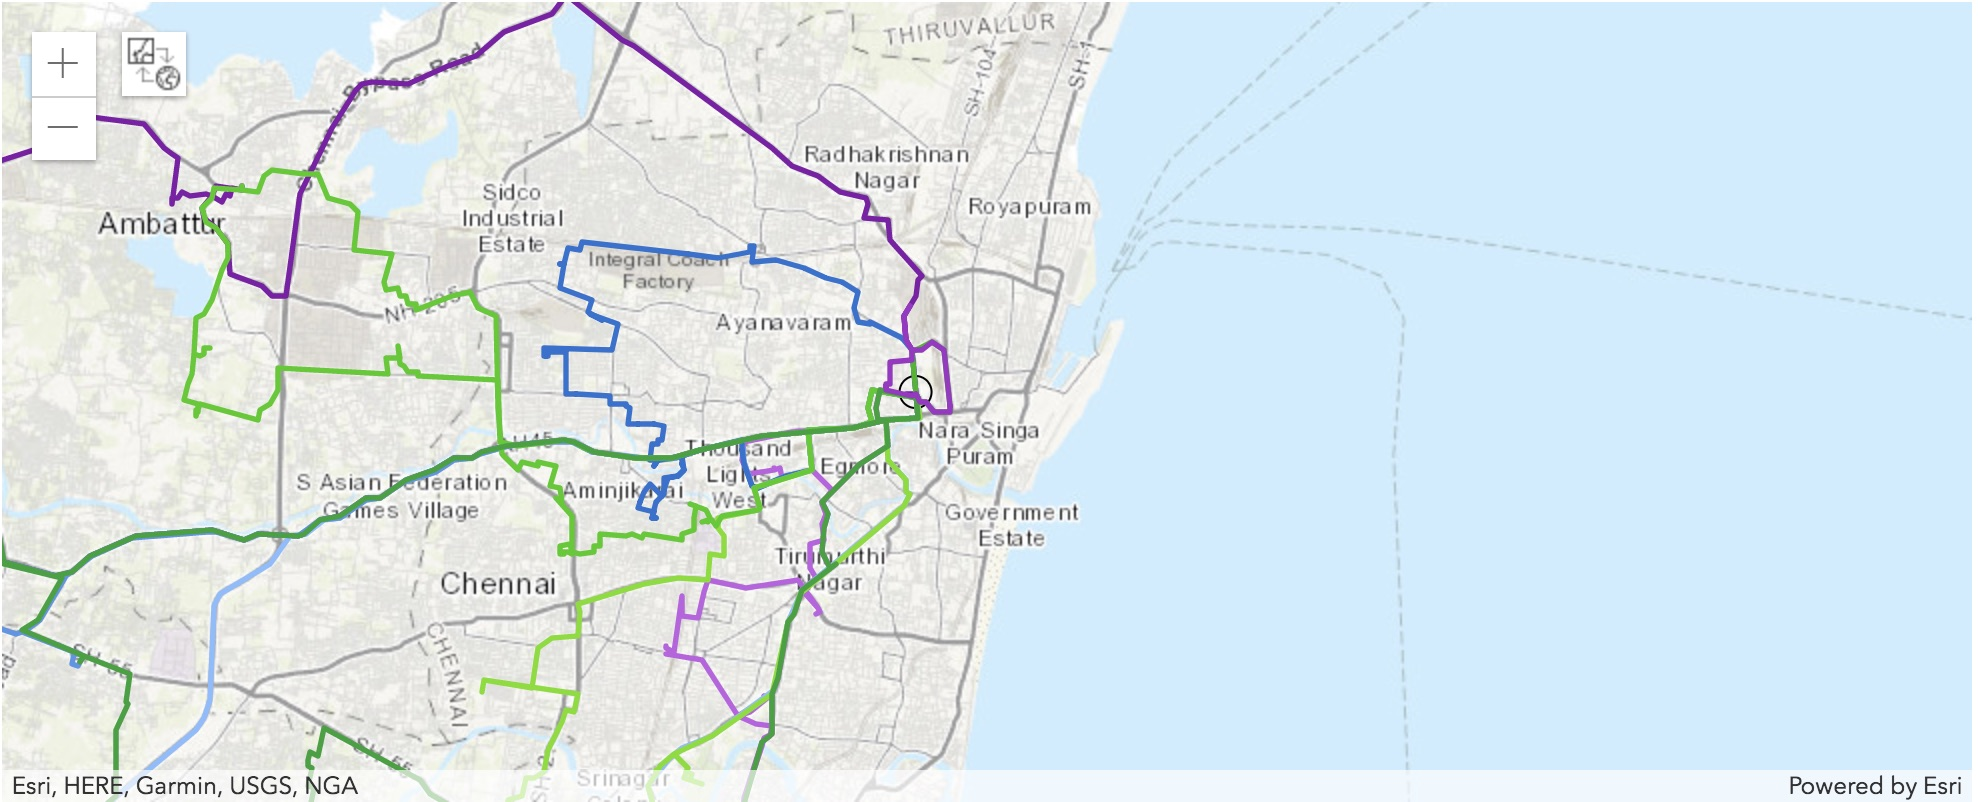

In [87]:
routemap = gis.map("Chennai")
routemap

In [76]:
nehru_stadium = geocode('Jawaharlal Nehru Stadium, Chennai')[0]
routemap.draw(nehru_stadium, {"title": "Nehru Stadium", 
                              "content": "Chennai Flood Relief Center"})

In [77]:
start_time = datetime.datetime(2015, 12, 13, 9, 0)

In [ ]:
routes = arcgis.features.use_proximity.plan_routes(
    relief_centers, 
    15, 
    15, 
    start_time, 
    nehru_stadium, 
    stop_service_time=30)
routemap.add_layer(routes['routes_layer'])

In [ ]:
routemap.add_layer(routes['assigned_stops_layer'])

Once the routes have been generated, they can be given to drivers, and used to ensure that relief material is promptly delivered to those in need and help alleviate the suffering they are going through.